In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import beta as beta_dist
from scipy.special import hyp2f1
from scipy.special import beta as beta_func
from scipy.integrate import dblquad
import utils
import re
from functools import partial
import matplotlib.pyplot as plt


In [231]:
input = utils.load_data([
    "../results/synthetic/1000/set4_aggregated/"
], "_x80_*")

data2 = utils.merge_exact(input, "exact_data_based")
#data2 = data2[(~data2.identifiable) & data2.selector]

#data_ps1_0 = data[data['index'] == 2] 
#data_ps1_1 = data[data['index'] == 1]
#data = data[data['index'] > 2]


In [244]:
sum(data2.identifiable)

370

In [239]:
LIMITARE a .1 upper - lower

370

In [ ]:
cols = [ int(re.match("pns_([0-9]+)", c)[1]) for c in data.columns if re.match("pns_[0-9]+",c) ]
cols.sort()
pns_l = data[[f"pns_{c}" for c in cols]].min(axis=1)

In [117]:
def fit(row, n, eps=0.0001) :
    samples = row[[f"pns_{c}" for c in range(n)]].values.astype(float)
    
    pos = row['pns_l_x'] - eps
    scale = row['pns_u_x'] - row['pns_l_x'] + 2 * eps
    params = beta_dist.fit(samples, floc = pos, fscale = scale)
    
    return params[0:2]


integral of scipy calls the fuction passing the inner variable first. 
 
Return the double (definite) integral of ``func(y, x)`` from ``x = a..b``
and ``y = gfun(x)..hfun(x)``.

In [217]:

def _p_beta2(x, y, L, alpha, beta, n):
    return (
        (
            ((L + x) ** alpha) *  hyp2f1(alpha, 1 - beta, alpha + 1, (L + x) / (L + x + y)) -
            (x ** alpha) * hyp2f1(alpha, 1 - beta, alpha + 1, x / (L + x + y))
        ) / (
            alpha * ((L + x + y) ** alpha) * beta_func(alpha, beta)  
        )
    ) ** n
    


def p_beta_warn(row, n, delta=None, eps = None): 
    import warnings
    with warnings.catch_warnings(record=True) as w:
        res = p_beta(row, n, delta, eps)
        return [res, len(w)]

def p_beta(row, n, delta=0.1, eps = None):
    with warnings.catch_warnings(record=True) as w:
        alpha, beta = fit(row, n)
        a = min(row[[f'pns_{i}' for i in range(n)]])
        b = max(row[[f'pns_{i}' for i in range(n)]]) 

        L = b - a

        if eps is not None:
            delta = eps * 2 * L 

        f = partial(_p_beta2, L = L, alpha = alpha, beta = beta, n = n)

        num, e1 = dblquad(f, 0, delta / 2, lambda y: 0, lambda y: delta / 2 )


        #f(y1, x1), x1_, x1^, y1_, y1^

        den, e2 = dblquad(lambda x,y: f(x, y), 0,  a + (1 - b), lambda y: 0, lambda y: a + (1 - b) - y)

        return [num/den, e1, e2, num, den, len(w)]


def p_unif(row, n, delta=0.1):
    b = row['pns_u_x'] 
    a = row['pns_l_x']
    L = b - a
    eps = delta / (2*L)
    return (1 + (1 + 2*eps)**(2 - n) - 2 * (1+ eps) ** (2-n)) / (1 - L ** (n - 2) - (n - 2) * (1 - L) * L ** (n - 2))

In [ ]:
def prob_unif_data(data, n, delta):
    a = data['pns_u_x'] 
    b = data['pns_l_x']
    L = b - a
    eps = delta / (2*L)
    return (1 + (1 + 2*eps)**(2 - n) - 2 * (1+ eps) ** (2-n)) / (1 - L ** (n - 2) - (n - 2) * (1 - L) * L ** (n - 2))

In [ ]:
u = data.apply(partial(fit,n=80), axis=1)
pd.DataFrame(u.tolist(), index=u.index, columns=["alpha_80", "beta_80"]).boxplot()

In [133]:
xx.shape

(522, 214)

In [218]:
xx = data
eps = 0.05
n=40
x50 = xx.apply(partial(p_beta, n=n, eps=eps), axis=1)

0.00039747608941728105

In [165]:
import seaborn as sns

In [221]:
a50 = np.array([a for a in x50])
c = pd.DataFrame(a50, columns=["p","e1","e2","num","den", "w"])
c[np.abs(c.p - 9.08) < 0.1]

,p,e1,e2,num,den,w
243,9.080148,5.302277e-10,1.414872e-08,0.000049,0.000005,0.0


In [214]:
c[np.abs(c.p -9.08) < 0.01]



,p,e1,e2,num,den
243,9.080148,5.302277e-10,1.414872e-08,0.000049,0.000005


In [191]:
c[(c.den / c.e2 < 0.1) | (c.num/c.e1 < 0.1)]

,p,e1,e2,num,den
5,6.126521e+01,3.354821e-09,1.349493e-08,2.222938e-08,3.628385e-10
6,1.127436e+03,3.747458e-09,5.871718e-09,9.652087e-09,8.561092e-12
7,2.802614e+04,2.238431e-09,1.180862e-10,4.840360e-09,1.727087e-13
8,2.802614e+04,2.238431e-09,1.180862e-10,4.840360e-09,1.727087e-13
15,1.796303e+02,1.471791e-08,1.904304e-09,4.834042e-10,2.691106e-12
16,2.233147e+03,1.454636e-08,1.738594e-11,5.500652e-11,2.463184e-14
17,2.528671e+02,1.461214e-08,1.447517e-09,5.188767e-10,2.051974e-12
34,1.754873e+08,1.404211e-08,1.820005e-15,4.678119e-10,2.665788e-18
35,1.754873e+08,1.404211e-08,1.820005e-15,4.678119e-10,2.665788e-18
43,8.322555e+01,1.197194e-08,2.635690e-09,1.488052e-08,1.787975e-10


/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

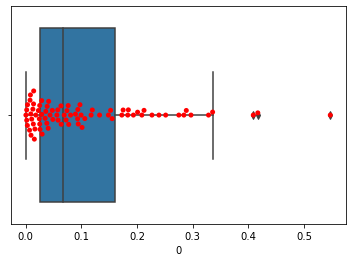

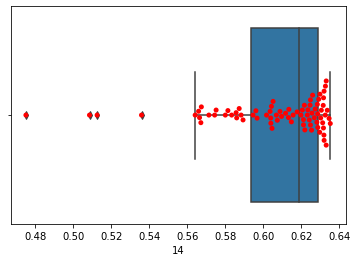

In [181]:
n=80
item = c[c.p<0.1].index
for i in item:
    plt.figure()
    sns.boxplot(data.iloc[i][[f"pns_{i}" for i in range(n)]])
    sns.swarmplot(data.iloc[i][[f"pns_{i}" for i in range(n)]], color="red")

In [135]:
a = np.array([ np.array(a) for a in x])
sum(a[:,0] > 1)

69

{'whiskers': [<matplotlib.lines.Line2D at 0x7f852a2c23a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f852a2c2940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f852a2c20a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f852a2c2dc0>],
 'fliers': [],
 'means': []}

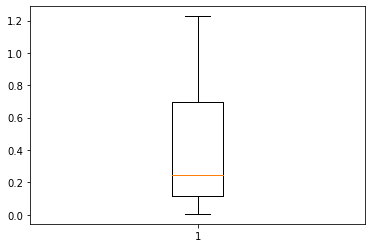

In [108]:
plt.boxplot(x, showfliers=False)

In [ ]:
import warnings
warnings.filterwarnings("always")
data.iloc[[71,275, 276, 277, 278]].apply(partial(p_beta, n=n, eps=0.01), axis=1) # .apply(partial(fit,n=80), axis=1)

In [ ]:
xx = data
delta = 0.05
n=80
x = xx[(xx.pns_u_x - xx.pns_l_x) < 0.005].apply(partial(p_beta, n=n, delta=delta), axis=1)

In [ ]:
plt.boxplot(x)

In [ ]:
n = 80
deltas=[ 0.01, 0.025, 0.05, 0.075, 0.1, 0.25 ]
for delta in [ 0.1, 0.25 ]:
    print(delta)
    f = partial(p_beta, n=n, delta=delta)
    data[f'p_beta_{n}_{delta}'] = data.apply(f, axis=1)
    data[f'p_unif_{n}_{delta}'] = prob_unif_data(data, n, delta)

data.to_csv(f"temp_n{n}_many_{delta}.csv")

In [ ]:
print((np.isnan(data[cols])).rename(mapping, axis=1).sum())
print((data[cols]>1.001).rename(mapping, axis=1).sum())

print((data[cols]<=1.001).rename(mapping, axis=1).sum())


In [ ]:
n =80

In [ ]:
cols = [f"p_beta_{n}_{delta}" for delta in deltas ]
mapping = { col:col.split("_")[-1] for col in cols}

c = [ col.split("_")[-1] for col in cols ]
dati_box = data[data[cols]< 1.001][cols].rename(mapping, axis=1)
#dati_box = data[data[c]< 1.001][c]
dati_box.boxplot()


In [ ]:
data = pd.read_csv("temp_n80_many_0.25.csv")

In [ ]:
pbeta_cols = np.array([[float(c.split("_")[-1]), c] for c in data.columns if c[0:3] == "p_b" ])
eps_cols = []
for delta, col in pbeta_cols:
    data[f"eps_{delta}"] = data[col] / (2 * (data["pns_u_x"] - data["pns_l_x"]))
    eps_cols.append(f"eps_{delta}")

#data[[ c for c in pbeta_cols + ["pns_l_x", "pns_u_x"]]
#for d in col

data[["eps_0.05"]].boxplot()


In [ ]:
for n in range(80):
    cols = [f"pns_{i}" for i in range(n+1)]
    a = data[cols].min(axis=1)
    b = data[cols].max(axis=1)
    l = data.pns_l_x
    u = data.pns_u_x

    data[f'error_r_{n}'] = np.sqrt(((l - a) ** 2 + (u - b) ** 2) / 2) / (u - l)

In [ ]:
ns = [20, 40, 60]

nsname=str.join("-", np.array(ns).astype(str))
err_cols = [f'error_r_{i}' for i in ns]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
d = data

dta = pd.melt(d[err_cols])
dta["n"]=dta.variable.str.split("_").str[-1].astype(int)
sns.boxplot(x="n", y="value", data=dta, hue_order=ns)
plt.title("PNS EMCC Runs diff vs full by treewidth")
plt.tight_layout()
plt.savefig(f"PNS_runs_all_nooutliers_{nsname}.png")
plt.show()

dta[['n','value']].to_csv(f"PNS_runs_all_nooutliers_{nsname}.csv")

# save boxplots
with np.printoptions(linewidth=100000):
    utils.boxplots(dta, "value", "n").to_csv(f"PNS_runs_all_nooutliers_{nsname}_boxplots.csv")

Merge stuff